<a href="https://colab.research.google.com/github/snehitvaddi/Brain-Tumor-Classification-DataSet/blob/master/Copy_of_Brain_Tumor_CNN%26TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, I've used **CNN** to perform Image Classification on the Brain Tumor dataset.<br>
Since this dataset is small, if we train a neural network to it, it won't really give us a good result.<br>
Therefore, I'm going to use the concept of **Transfer Learning** and also custom CNN to train the model to compare accurate results.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Note:** Before you run, Import the dataset into your google drive and then try updating the paths specific to yout drive.

## 📚 Dataset: https://drive.google.com/drive/folders/1YCDqMawf0Iua64rV66z24rgAYDdTMkNc?usp=sharing

# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Projects-for-Sale/Brain_Tumor_Classification/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

---

# Data Preperation

In [4]:
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

In [5]:
!pwd

/content


We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [6]:
X_train = []
y_train = []
image_size = 150
dir = '/content/drive/MyDrive/Projects-for-Sale/Brain_Tumor_Classification/dataset'
for i in labels:
    folderPath = os.path.join(dir,'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(dir,'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 64/64 [00:39<00:00,  1.63it/s]


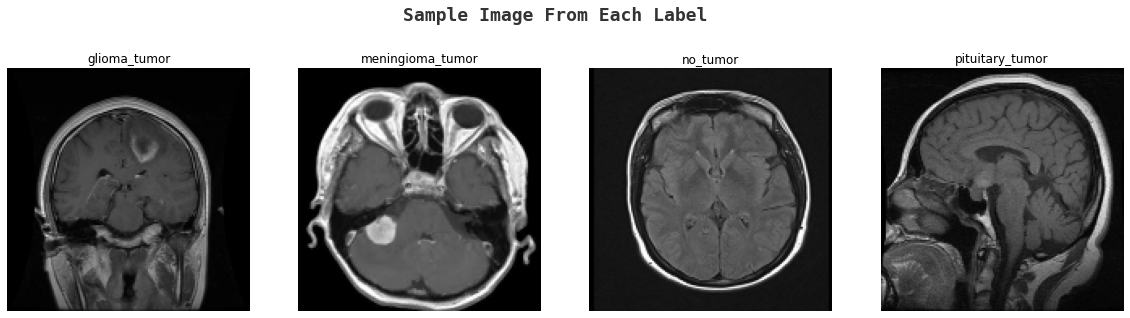

In [7]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [8]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [9]:
X_train.shape

(1350, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [11]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

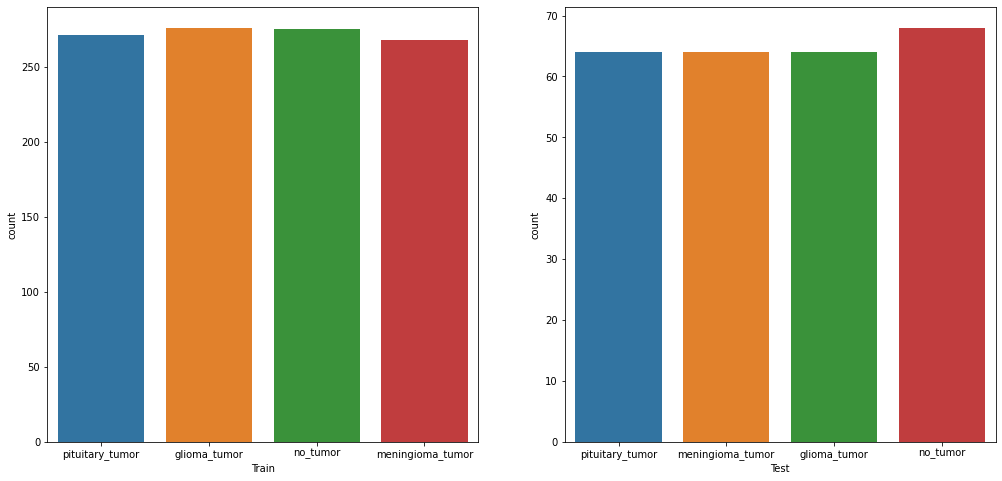

In [12]:
train_labels = []
test_labels = []

dir = '/content/drive/MyDrive/Projects-for-Sale/Brain_Tumor_Classification/dataset'

img_size= 300

for i in os.listdir(dir+'/Training/'):
    for j in os.listdir(dir+"/Training/"+i):
       train_labels.append(i)
        
for i in os.listdir(dir+'/Testing/'):
    for j in os.listdir(dir+"/Testing/"+i):
        test_labels.append(i)

plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

---

## Custom CNN

In [13]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.models import load_model

# Start training freshly
tf.keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(image_size,image_size,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                        

In [16]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("IEEE-model-28.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [17]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =28, verbose=1, batch_size=16,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/28
69/69 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.7941
Epoch 1: val_accuracy improved from -inf to 0.70492, saving model to IEEE-model-28.h5
69/69 [==============================] - 2s 34ms/step - loss: 0.5527 - accuracy: 0.7941 - val_loss: 0.8005 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 2/28
67/69 [============================>.] - ETA: 0s - loss: 0.5080 - accuracy: 0.7966
Epoch 2: val_accuracy improved from 0.70492 to 0.77049, saving model to IEEE-model-28.h5
69/69 [==============================] - 2s 32ms/step - loss: 0.5124 - accuracy: 0.7969 - val_loss: 0.5865 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 3/28
67/69 [============================>.] - ETA: 0s - loss: 0.4817 - accuracy: 0.8368
Epoch 3: val_accuracy did not improve from 0.77049
69/69 [==============================] - 2s 32ms/step - loss: 0.4819 - accuracy: 0.8362 - val_loss: 0.6675 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 4/28
67/69 [============================>.] - ETA: 0s - l

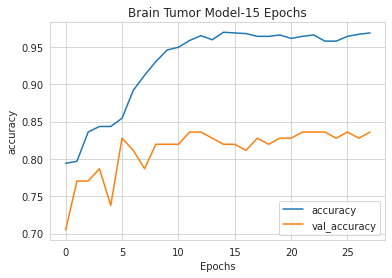

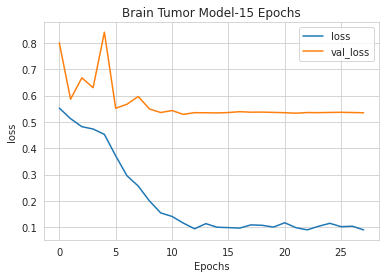

In [18]:
#Visualize Training
def plot_graphs(history, string):
    sns.set_style("whitegrid")
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title("Brain Tumor Model-15 Epochs")
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

In [19]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86        42
           1       0.67      0.70      0.68        23
           2       0.80      0.95      0.87        38
           3       0.97      0.94      0.95        32

    accuracy                           0.85       135
   macro avg       0.84      0.84      0.84       135
weighted avg       0.86      0.85      0.85       135



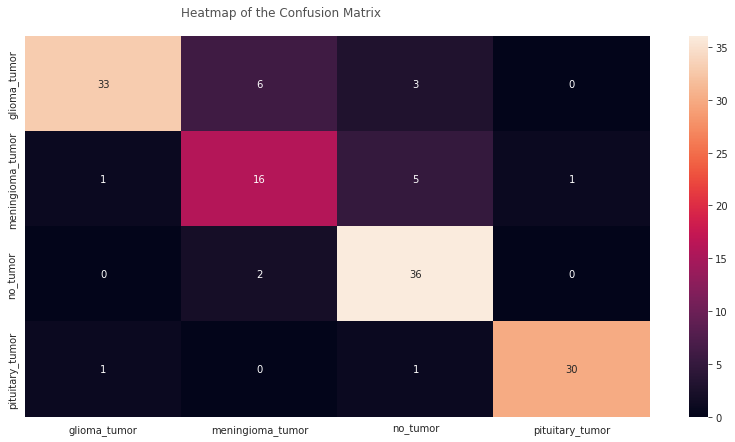

In [20]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=12,y=0.92,x=0.28,alpha=0.8)

plt.show()

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [21]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16719872/16705208 [==============================] - 0s 0us/step


**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [22]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

We finally compile our model.

In [24]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [25]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("EfficientNetD0-12.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

**Note**: The training takes alot of time! ~ 1 hours for me (Using CPU)<br>

1.   List item
2.   List item


Barely took 5 minutes with the GPU.

In [26]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
35/35 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.7640
Epoch 1: val_accuracy improved from -inf to 0.79508, saving model to EfficientNetD0-12.h5
35/35 [==============================] - 29s 426ms/step - loss: 0.6248 - accuracy: 0.7640 - val_loss: 0.6442 - val_accuracy: 0.7951 - lr: 0.0010
Epoch 2/12
35/35 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.8994
Epoch 2: val_accuracy improved from 0.79508 to 0.86885, saving model to EfficientNetD0-12.h5
35/35 [==============================] - 11s 322ms/step - loss: 0.2949 - accuracy: 0.8994 - val_loss: 0.3199 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 3/12
35/35 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9607
Epoch 3: val_accuracy improved from 0.86885 to 0.90164, saving model to EfficientNetD0-12.h5
35/35 [==============================] - 11s 320ms/step - loss: 0.1309 - accuracy: 0.9607 - val_loss: 0.3611 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 4

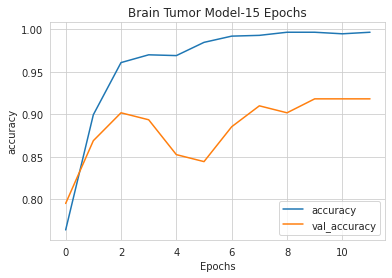

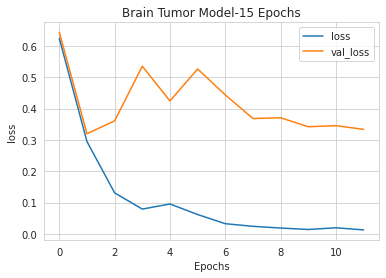

In [27]:
#Visualize Training
def plot_graphs(history, string):
    sns.set_style("whitegrid")
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title("Brain Tumor Model-15 Epochs")
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [28]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [29]:
pred

array([0, 0, 2, 1, 0, 0, 0, 3, 2, 2, 2, 3, 0, 3, 1, 0, 2, 2, 2, 2, 0, 3,
       3, 0, 3, 3, 3, 3, 3, 0, 1, 1, 2, 2, 2, 2, 0, 1, 3, 1, 3, 0, 1, 1,
       0, 1, 0, 0, 0, 3, 3, 2, 0, 2, 0, 3, 2, 3, 0, 3, 0, 3, 0, 2, 0, 3,
       2, 0, 0, 2, 0, 2, 2, 2, 3, 2, 3, 2, 0, 1, 3, 0, 2, 2, 2, 0, 3, 0,
       1, 2, 0, 0, 3, 0, 3, 0, 3, 1, 2, 2, 1, 1, 2, 0, 0, 2, 2, 2, 3, 2,
       2, 2, 3, 0, 3, 2, 0, 3, 3, 3, 2, 0, 0, 1, 2, 3, 2, 3, 2, 0, 0, 1,
       0, 2, 0])

---

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [30]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       1.00      0.70      0.82        23
           2       0.90      1.00      0.95        38
           3       0.94      1.00      0.97        32

    accuracy                           0.94       135
   macro avg       0.95      0.92      0.93       135
weighted avg       0.94      0.94      0.94       135



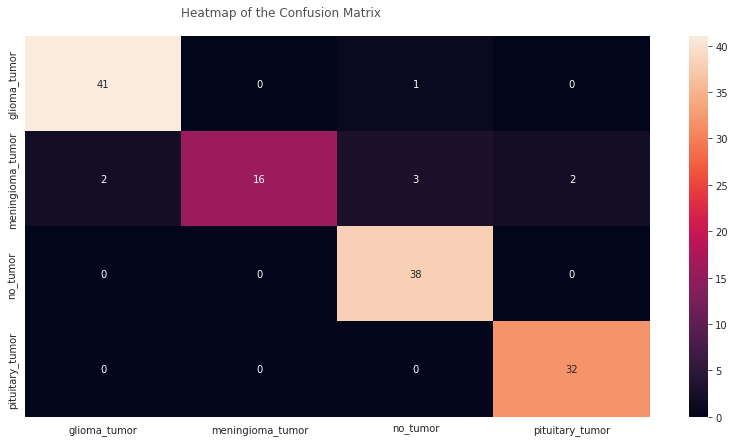

In [31]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=12,y=0.92,x=0.28,alpha=0.8)

plt.show()

---

# Bonus Content: Widgets

I've made these Widgets in which we can upload images from our local machine and predict whether the MRI scan has a Brain Tumour or not and to classify which Tumor it is.<br>
Unfortunately, it doesn't work on Kaggle but you can play around with this by downloading the notebook on your machine :)

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

This is where you can upload the image by clicking on the **Upload** button:

In [ ]:


def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')

uploader = widgets.FileUpload()
display(uploader)
button = widgets.Button(description='Predict')
out = widgets.Output()

button.on_click(on_button_clicked)
widgets.VBox([button,out])

FileUpload(value={}, description='Upload')

After uploading the image, you can click on the **Predict** button below to make predictions:

In [ ]:
# !pip install jovian
import jovian
jovian.commit(environment=None)

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab


---

# <center>Thank You!